In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wsi.indicators.poverty import build_poverty_df
from wsi.utils import processed_data_path, raw_data_path
from wsi.mapping.iso_name import ISO_NAME

index_baseline = pd.read_csv(processed_data_path("womens_safety_index_baseline.csv"))
filled_pov = index_baseline[['ISO_code', 'Year', 'Poverty', 'Economy']]

In [39]:
poverty_df = build_poverty_df()
poverty_df['Economy'] = poverty_df['ISO_code'].map(ISO_NAME)
poverty_df

,ISO_code,Year,Poverty,Economy
0,ALB,2002,1.1,Albania
1,ALB,2005,0.6,Albania
2,ALB,2008,0.2,Albania
3,ALB,2012,0.6,Albania
4,ALB,2014,1.0,Albania
...,...,...,...,...
1606,ZMB,2004,61.1,Zambia
1607,ZMB,2006,64.7,Zambia
1608,ZMB,2010,64.4,Zambia
1609,ZMB,2015,60.8,Zambia


In [40]:
# data from world bank, national poverty line
path = raw_data_path("indicators", "poverty_national.csv")
df = pd.read_csv(path, skiprows=4).iloc[:, :-1]
df_filtered = df[df['Indicator Code'] == 'SI.POV.NAHC']
df_pivot = df_filtered.set_index('Country Code').drop(columns=['Indicator Name', 'Indicator Code', 'Country Name'])
df_pivot.columns = df_pivot.columns.astype(int)
df_pivot = df_pivot.reset_index()  # Make Country Code a column
df_long = df_pivot.melt(id_vars='Country Code', var_name='Year', value_name='Poverty_national').rename(columns={'Country Code':'ISO_code'})
df_long.head()

,ISO_code,Year,Poverty_national
0,ABW,1960,NaN
1,AFE,1960,NaN
2,AFG,1960,NaN
3,AFW,1960,NaN
4,AGO,1960,NaN


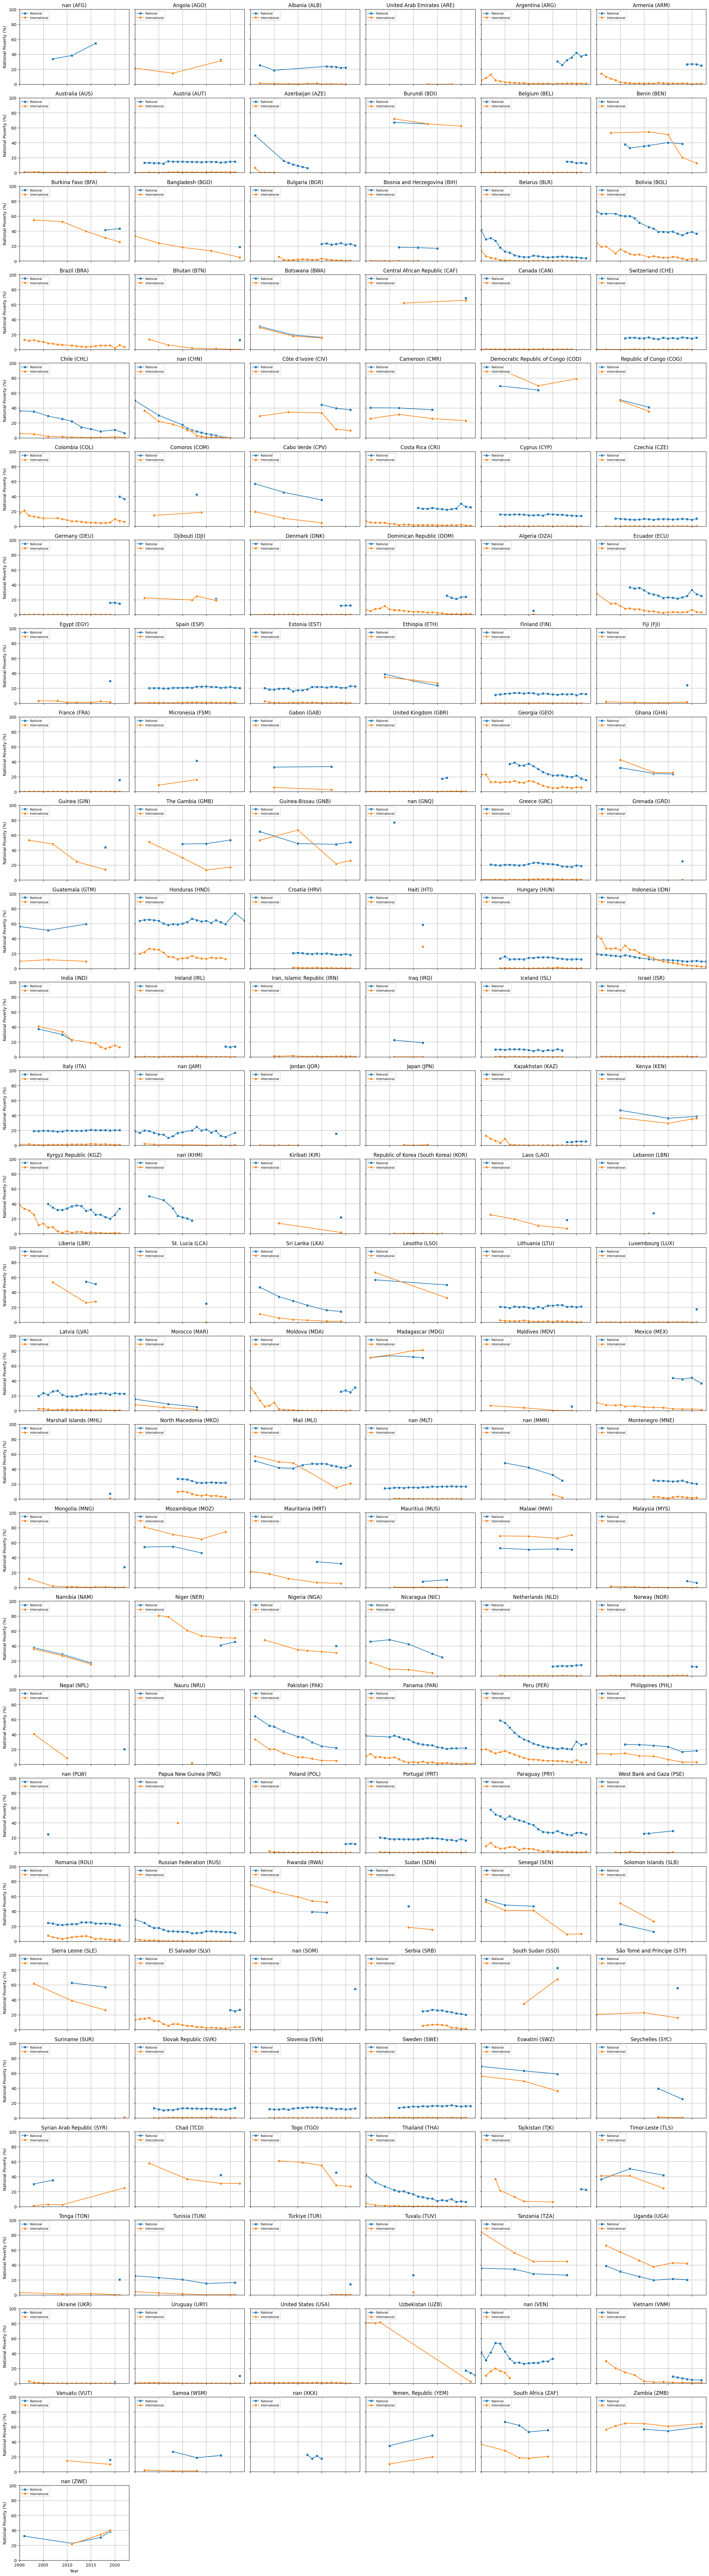

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# --- 1) Merge the two series on ISO_code & Year ---
df_merged = (
    pd.merge(df_long, poverty_df, on=['ISO_code','Year'], how='outer')
      .sort_values(['ISO_code','Year'])
)

# Rename columns for clarity
df_merged = df_merged.rename(columns={
    'Poverty_national': 'National Poverty (%)',
    'Poverty': 'International Poverty (%)'
})

# Drop rows where both series are missing
df_merged = df_merged.dropna(
    subset=['National Poverty (%)', 'International Poverty (%)'],
    how='all'
)

# --- 2) Setup plotting grid ---
countries = sorted(df_merged['ISO_code'].unique())
n_countries = len(countries)
n_cols = 6
n_rows = math.ceil(n_countries / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows),
                         sharex=True, sharey=True)
axes = axes.flatten()

# --- 3) Plot each country ---
for ax, iso in zip(axes, countries):
    sub = df_merged[df_merged['ISO_code'] == iso]
    if sub.empty:
        ax.set_visible(False)
        continue

    # Retrieve economy name
    economy = sub['Economy'].iloc[0]

    # Plot national series
    sns.lineplot(
        data=sub,
        x='Year', y='National Poverty (%)',
        marker='s', label='National', ax=ax, color='C0'
    )
    # Plot international series
    sns.lineplot(
        data=sub,
        x='Year', y='International Poverty (%)',
        marker='o', label='International', ax=ax, color='C1'
    )

    ax.set_title(f"{economy} ({iso})")
    ax.set_xlim(df_merged['Year'].min(), df_merged['Year'].max())
    ax.set_ylim(0, 100)    # percentages
    ax.grid(True)
    ax.legend(fontsize='x-small', loc='upper left')

# Hide any unused axes
for ax in axes[n_countries:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [42]:
df_merged[['National Poverty (%)', 'International Poverty (%)']].corr()

,National Poverty (%),International Poverty (%)
National Poverty (%),1.000000,0.653815
International Poverty (%),0.653815,1.000000


In [43]:
df_merged

,ISO_code,Year,National Poverty (%),International Poverty (%),Economy
177,AFG,2007,33.7,NaN,NaN
181,AFG,2011,38.3,NaN,NaN
186,AFG,2016,54.5,NaN,NaN
300,AGO,2000,NaN,21.4,Angola
308,AGO,2008,NaN,14.6,Angola
...,...,...,...,...,...
17222,ZMB,2022,60.0,64.3,Zambia
17266,ZWE,2001,32.2,NaN,NaN
17276,ZWE,2011,22.5,21.6,Zimbabwe
17282,ZWE,2017,30.4,34.2,Zimbabwe


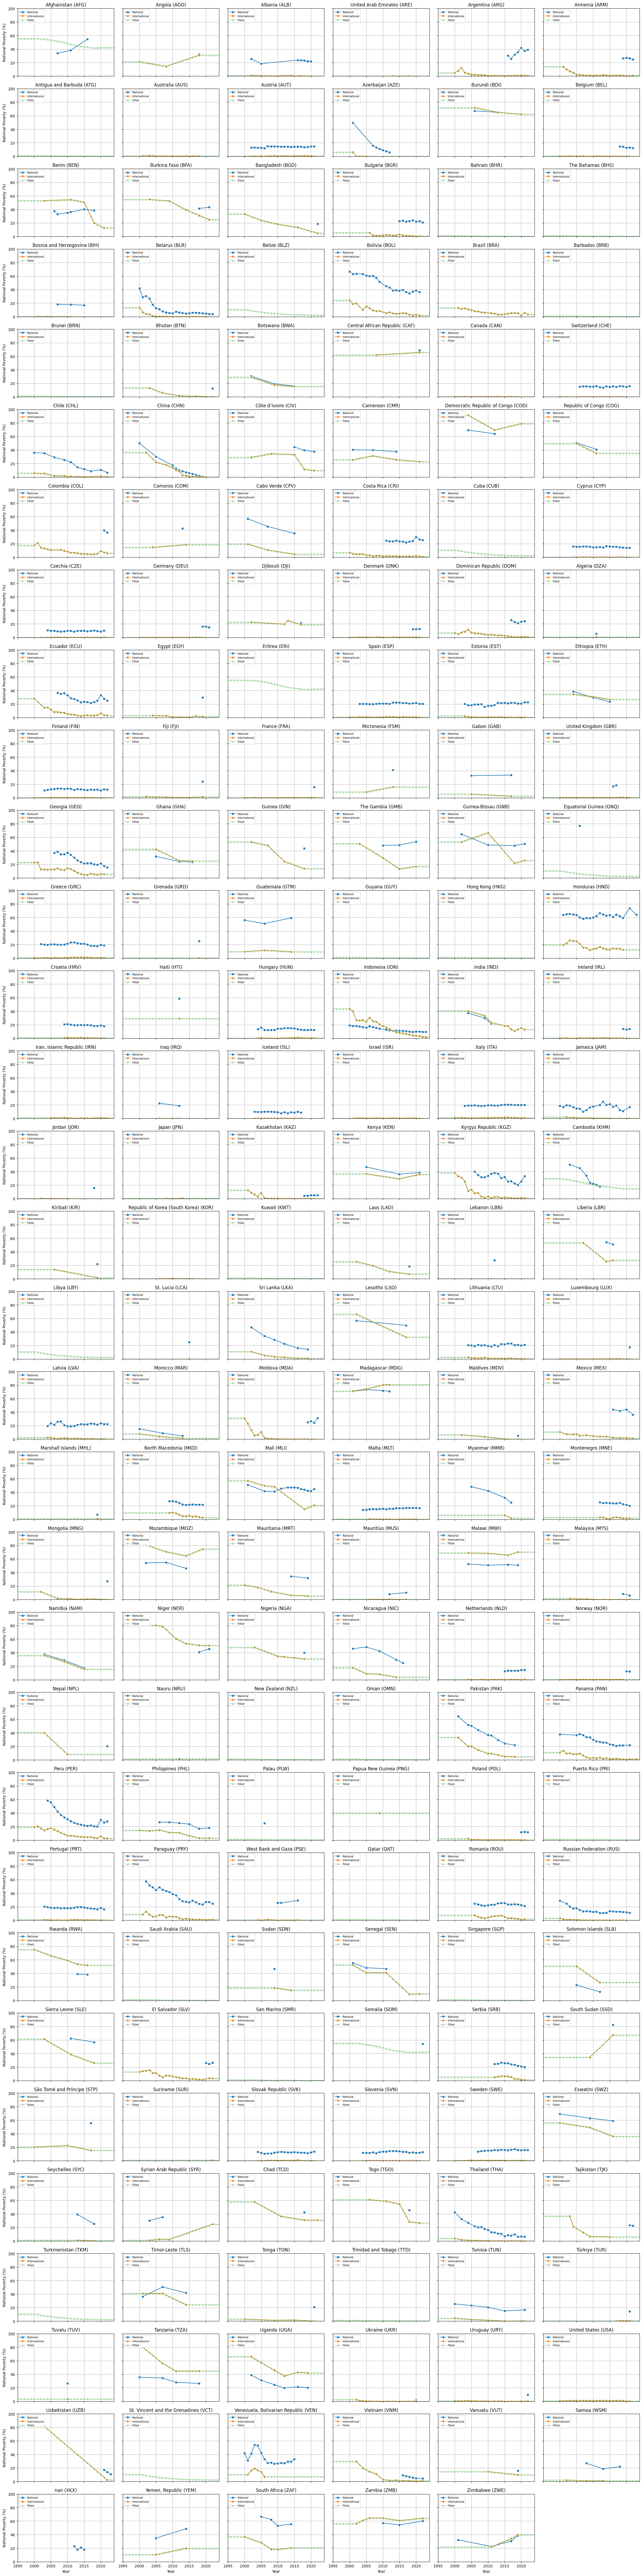

In [47]:


# --- 1) Merge the three series on ISO_code & Year ---
df_merged = (
    pd.merge(df_long, poverty_df[['ISO_code','Year','Poverty']], on=['ISO_code','Year'], how='outer')
      .rename(columns={'Poverty':'International Poverty (%)'})
      .merge(filled_pov, on=['ISO_code','Year'], how='outer')
      .rename(columns={'Poverty':'Filled Poverty (%)',
                       'Poverty_national':'National Poverty (%)'})
      .sort_values(['ISO_code','Year'])
)

# Drop rows where all three are missing
df_merged = df_merged.dropna(
    subset=['National Poverty (%)','International Poverty (%)','Filled Poverty (%)'],
    how='all'
)

# --- 2) Setup plotting grid ---
countries = sorted(df_merged['ISO_code'].unique())
n_countries = len(countries)
n_cols = 6
n_rows = math.ceil(n_countries / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows),
                         sharex=True, sharey=True)
axes = axes.flatten()

# --- 3) Plot each country ---
for ax, iso in zip(axes, countries):
    sub = df_merged[df_merged['ISO_code']==iso]
    if sub.empty:
        ax.set_visible(False)
        continue

    economy = sub['Economy'].iloc[0]

    # Plot national series
    sns.lineplot(
        data=sub,
        x='Year', y='National Poverty (%)',
        marker='s', label='National', ax=ax, color='C0'
    )
    # Plot international survey series
    sns.lineplot(
        data=sub,
        x='Year', y='International Poverty (%)',
        marker='o', label='International', ax=ax, color='C1'
    )
    # Plot filled series
    sns.lineplot(
        data=sub,
        x='Year', y='Filled Poverty (%)',
        marker='^', label='Filled', ax=ax, color='C2', alpha=0.4
    )

    ax.set_title(f"{economy} ({iso})")
    ax.set_xlim(df_merged['Year'].min(), df_merged['Year'].max())
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend(fontsize='x-small', loc='upper left')

# Hide any unused axes
for ax in axes[n_countries:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()
